In [1]:
import numpy as np
import pandas as pd
import dit
from dit.pid import *
from itertools import product
import matplotlib.pyplot as plt
from itertools import combinations
from joblib import Parallel, delayed
from dit.pid.pid import BasePID
from dit.pid.measures import *

# 0. Introduction
This notebook shows the calculation of the Möbius function on the redundancy lattice on 5 variables, also known as the free distributive lattice generated by 5 elements. 

In addition, it shows how to use this to calculate the Partial Information Decomposition (PID) on up to 5 variables. 

# 1. A class to calculating the algebraic PID
To interface nicely with `dit.pid`, we create a new class that inherits a `dit.pid.measures` class with the right redundancy measure. However, we do not want `dit` to calculate the atoms, as we can do it faster. We only use `dit` to calculate the redundancy measures. 

In [2]:
def calcPID(d, mfMat, antiChains, measure, onlyNonzero=True):
    '''
    d : dit Distribution
            The distribution to compute the decomposition on.
    mfMat : np.array or pd.Dataframe
            the matrix representation of the Möbius function
    antiChains : list or array of tuples of tuples, e.g. 
            the antichains, as indices
    measure : `dit.pid` class
            the redundancy measure to use
    onlyNonzero : Boolean, True
            choose to return only nonzero (i.e. >1e-5) atoms. 
    '''
    class RedundancyOnlyPID(measure):
        def __init__(self, dist, mfMat, antiChains, inputs=None, output=None, reds=None, pis=None, **kwargs):
            if output is None:
                output = dist.rvs[-1]
            if inputs is None:
                inputs = [var for var in dist.rvs if var[0] not in output]
            self._dist = dist
            self._inputs = tuple(map(tuple, inputs))
            self._output = tuple(output)
            self._kwargs = kwargs
            self._lattice = antiChains
            self._mfMat = mfMat
            self._total = None
            self._reds = {} if reds is None else reds
            self._pis = {} if pis is None else pis
            self._compute()

        def _compute(self):
            '''
            Calculate the Redundancies
            '''
            self._reds = {ac: self._measure(d, ac, self._output) for ac in self._lattice}
            self._compute_mobius_inversion()

        def _compute_mobius_inversion(self):
            '''
            Calculate the partial information atoms
            '''
            atoms, reds = list(zip(*self._reds.items()))
            self._pis = dict(list(zip(atoms, np.dot(reds, self._mfMat))))
    
    r = RedundancyOnlyPID(d, mfMat, antiChains)
    if onlyNonzero:
        return {k: v for k, v in r._pis.items() if ~np.isclose(v, 0, atol=1e-5)}
    else:
        return r

In [3]:
# Two function to convert antichains (ac) between strings and tuples

def acStringToTuple(ac):
    return tuple([tuple([int(x) for x in block]) for block in ac.split('|')])

def acTupleToString(ac):
    return '|'.join([''.join([str(x) for x in block]) for block in ac])


def isAntichain(S, returnBool=False):
    '''
    Checks whether a given list of lists (S) is an antichain under subset inclusion
    Returns the set itself by default, or a Boolean answer when returnBool=True
    '''
    for i in range(len(S)-1):
        for j in range(i+1, len(S)):
            if set(S[i]).issubset(set(S[j])) or set(S[j]).issubset(set(S[i])):
                return False
    if returnBool:
        return True
    else:
        return S

def complement(S, ref):
    return [(set(ref) - set(s)) for s in S]

def generatedIdeal(S):
    # the ideal generated by S is the set of all sets that are subsets of elements of S:
    ideal = []
    for s in S:
        for i in range(1, len(s)+1):
            ideal += [tuple(set(x)) for x in product(s, repeat=i)]

    return list(set(ideal))
    
def MF(a1, a2, ref):
    '''
    Given two antichains a1 and a2, and the reference set all of indices (ref),
    this returns the Möbius functions, using the Birkhoff representation formula. 
    '''
    id1 = set(generatedIdeal(complement(a1, ref)))
    id2 = set(generatedIdeal(complement(a2, ref)))
    diff = tuple(id1 - id2)
    
    if len(id2-id1) != 0:
        return 0

    if isAntichain(diff, returnBool=True):
        return (-1)**(len(diff))
    else:
        return 0

# 2. Calculating the Möbius function
Calculate the full Möbius function on N variables, saved as csv in a folder called antichain_outputs. 

N=5 is excluded to make this efficient, as it takes about an hour on Macbook M2. 

In [4]:
for N in [2, 3, 4]:
    print('starting calculation on N=', N)
    subsets = [list(subset) for k in range(1, N+1) for subset in combinations(range(N), k)]

    # A maximum of n choose n/2 subsets can appear in an antichain
    maxSize = len(list(combinations(np.arange(N), np.floor(N/2).astype(int))))+1

    print('Determining antichains')
    # Check all possible combinations of subsets in parallel:
    results = Parallel(n_jobs=-1)(delayed(isAntichain)(comb)  for i in range(1, maxSize) for comb in [list(x) for x in combinations(subsets, i)])

    antiChains = []
    for i in range(len(results)):
        if results[i] != 0:
            antiChains.append(results[i])

    print('Number of antichains:', len(antiChains))
    print('(This should be 1, 4, 18, 166, 7579, etc. That is, the N-th Dedekind number minus two.)')
    pd.Series(antiChains).to_csv(f'antichain_outputs/antiChains_N={N}.csv')

    print('Calculating Mobius function')
    mfMat = np.zeros((len(antiChains), len(antiChains)))
    for i, ac1 in enumerate(antiChains):
        # print(i, ac1)
        for j, ac2 in enumerate(antiChains):
            mfMat[i, j] = MF(ac1, ac2, tuple(np.arange(N)))

    print('Saving Mobius function')
    acs_str = [acTupleToString(ac) for ac in antiChains]
    pd.DataFrame(mfMat, index=acs_str, columns=acs_str).to_csv(f'antichain_outputs/antiChainLattice_mobiusFns_N={N}.csv')
    print('Done!')
    print()


starting calculation on N= 2
Determining antichains
Number of antichains: 4
(This should be 1, 4, 18, 166, 7579, etc. That is, the N-th Dedekind number minus two.)
Calculating Mobius function
Saving Mobius function
Done!

starting calculation on N= 3
Determining antichains
Number of antichains: 18
(This should be 1, 4, 18, 166, 7579, etc. That is, the N-th Dedekind number minus two.)
Calculating Mobius function
Saving Mobius function
Done!

starting calculation on N= 4
Determining antichains
Number of antichains: 166
(This should be 1, 4, 18, 166, 7579, etc. That is, the N-th Dedekind number minus two.)
Calculating Mobius function
Saving Mobius function
Done!



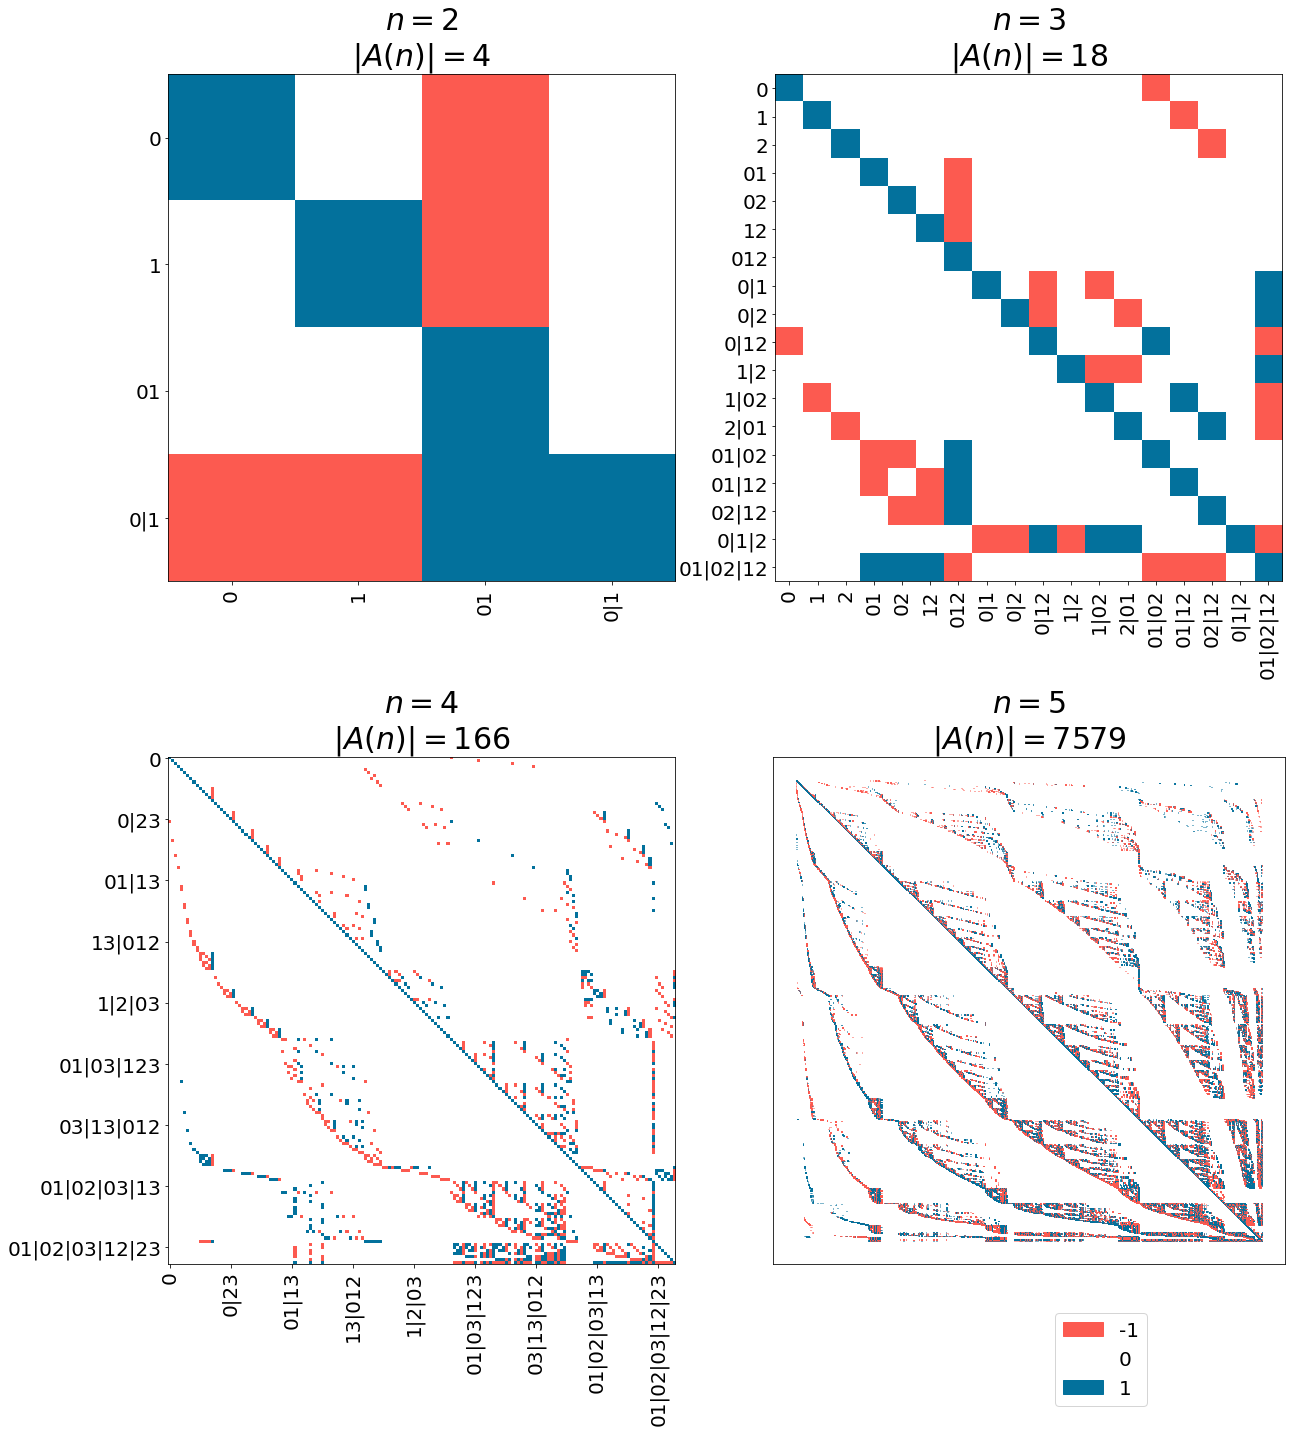

In [5]:
# Create the figure and axes
fig, ax = plt.subplots(2, 2, figsize=(20, 20))

# Define a discrete colormap
cmap = plt.cm.colors.ListedColormap(['#fc5a50', 'white', '#03719c'])
# cmap = plt.cm.viridis
bounds = [-1.5, -0.5, 0.5, 1.5]
norm = plt.cm.colors.BoundaryNorm(bounds, cmap.N)

# Iterate over different values of N
for N in [2, 3, 4, 5]:
    if N == 2:
        cax = ax[0, 0]
    elif N == 3:
        cax = ax[0, 1]
    elif N == 4:
        cax = ax[1, 0]
    elif N == 5:
        cax = ax[1, 1]

    mf = pd.read_csv(f'antichain_outputs/antiChainLattice_mobiusFns_N={N}.csv', index_col=0)
    # resort = np.argsort(np.linalg.inv(mf.values).sum(axis=0))

    acs = pd.read_csv(f'antichain_outputs/antiChains_N={N}.csv', index_col=0).values
    acs = [x[0].replace('], [', '|').replace(', ', '').replace(']', '').replace('[', '') for x in acs]

    if N < 5:
        cax.imshow(mf.values, cmap=cmap)
    else:
        r, c = np.nonzero(mf.T.values)
        cax.scatter(r, c, c=mf.T.values[r, c], cmap=cmap, marker='s', s=0.1)
        cax.set_ylim(cax.get_ylim()[::-1])        # invert the axis
        cax.xaxis.tick_top()   

    # Customize ticks and labels for the plot
    if N < 4:
        cax.set_xticks(range(len(acs)))
        cax.set_yticks(range(len(acs)))
        cax.set_xticklabels(acs, rotation=90, fontsize=20)
        cax.set_yticklabels(acs, fontsize=20)
    elif N == 4:
        cax.set_xticks(range(len(acs))[::20])
        cax.set_xticklabels(acs[::20], rotation=90, fontsize=20)
        cax.set_yticks(range(len(acs))[::20])
        cax.set_yticklabels(acs[::20], fontsize=20)
    elif N == 5:
        cax.set_xticks([])
        cax.set_yticks([])

    cax.set_title(fr'$n={N}$' + '\n' + fr'$|A(n)|={len(acs)}$', fontsize=30)

# Add a legend to explain the color mapping
labels = ['-1', '0', '1']
handles = [plt.Rectangle((0, 0), 1, 1, color=cmap(i)) for i in range(len(labels))]
plt.legend(handles, labels, loc='lower right', bbox_to_anchor=(0.75, -0.3), fontsize=20)

plt.tight_layout(rect=[0, 0, 0.9, 1])

plt.show()

# 3. Calculate the PID on some example distributions

In [20]:
# Different distributions to try the PID on

def randBinDist(N):
    outcomes = [''.join(x) for x in product('01', repeat=N)]
    probs = abs(np.random.randn(len(outcomes)))
    probs = probs/np.sum(probs)
    d = dit.Distribution(outcomes, probs)
    return d

def modDist(N, mod):
    outcomes = [''.join(x) for x in product('01', repeat=N)]
    probs = [1 if x.count('1') % mod == 0 else 0 for x in outcomes]
    probs = probs/np.sum(probs)
    d = dit.Distribution(outcomes, probs)
    return d

def XORdist(N):
    return modDist(N, 2)
    
def redDist(N):
    return modDist(N, N)

def indepDist(N):
    outcomes = [''.join(x) for x in product('01', repeat=N)]
    probs = [1/len(outcomes) for _ in outcomes]
    probs = probs/np.sum(probs)
    d = dit.Distribution(outcomes, probs)
    return d

def unqDist(N):
    outcomes = [''.join(x) for x in product('01', repeat=N)]
    probs = [1 if (x[-1] == x[0])  else 0 for x in outcomes]
    probs = probs/np.sum(probs)
    d = dit.Distribution(outcomes, probs)
    return d

In [28]:
pidMeasures = [PID_WB, PID_MMI]

In [29]:
N=5
mfMat = pd.read_csv(f"antichain_outputs/antiChainLattice_mobiusFns_N={N}.csv", index_col=0)
acs = [acStringToTuple(ac) for ac in mfMat.columns]

In [9]:
d = unqDist(N+1)
unqPIDs = []
for m in pidMeasures:
    print(m)
    unqPIDs.append(calcPID(d, mfMat, acs, m))
    print()

<class 'dit.pid.measures.imin.PID_WB'>

<class 'dit.pid.measures.immi.PID_MMI'>

<class 'dit.pid.measures.ipm.PID_PM'>



In [13]:
d = XORdist(N+1)
xorPIDs = []
for m in pidMeasures:
    print(m)
    xorPIDs.append(calcPID(d, mfMat, acs, m))
    print()

<class 'dit.pid.measures.imin.PID_WB'>

<class 'dit.pid.measures.immi.PID_MMI'>

<class 'dit.pid.measures.ipm.PID_PM'>



In [21]:
d = indepDist(N+1)
indepPIDs = []
for m in pidMeasures:
    print(m)
    indepPIDs.append(calcPID(d, mfMat, acs, m))
    print()

<class 'dit.pid.measures.imin.PID_WB'>

<class 'dit.pid.measures.immi.PID_MMI'>

<class 'dit.pid.measures.ipm.PID_PM'>



In [22]:
d = redDist(N+1)
redPIDs = []
for m in pidMeasures:
    print(m)
    redPIDs.append(calcPID(d, mfMat, acs, m))
    print()

<class 'dit.pid.measures.imin.PID_WB'>

<class 'dit.pid.measures.immi.PID_MMI'>

<class 'dit.pid.measures.ipm.PID_PM'>



In [23]:
def largestFromDict(d, N):
    return dict(sorted(d.items(), key = lambda x: x[1], reverse = True)[:N])

In [24]:
for d in xorPIDs:
    print(largestFromDict(d, 10))
    print()

{((0, 1, 2, 3, 4),): 1.0}

{((0, 1, 2, 3, 4),): 1.0}

{((0, 1, 2, 3, 4),): 1.0}



In [25]:
for d in indepPIDs:
    print(largestFromDict(d, 10))
    print()

{}

{}

{}



In [26]:
for d in redPIDs:
    print(largestFromDict(d, 10))
    print()

{((0,), (1,), (2,), (3,), (4,)): 1.0}

{((0,), (1,), (2,), (3,), (4,)): 1.0}

{((0,), (1,), (2,), (3,), (4,)): 1.0}



In [27]:
for d in unqPIDs:
    print(largestFromDict(d, 10))
    print()

{((0,),): 1.0}

{((0,),): 1.0}

{((0, 1, 2, 3, 4),): 1.0, ((0,), (1,), (2,), (3,), (4,)): 1.0, ((0, 1, 2, 3), (0, 1, 2, 4), (0, 1, 3, 4), (0, 2, 3, 4), (1, 2, 3, 4)): 1.0, ((0, 1), (0, 2), (0, 3), (0, 4), (1, 2), (1, 3), (1, 4), (2, 3), (2, 4), (3, 4)): 1.0, ((0, 1, 2), (0, 1, 3), (0, 1, 4), (0, 2, 3), (0, 2, 4), (0, 3, 4), (1, 2, 3), (1, 2, 4), (1, 3, 4), (2, 3, 4)): 1.0, ((1, 2, 3, 4),): -1.0, ((1,), (2,), (3,), (4,)): -1.0, ((1, 2, 3), (1, 2, 4), (1, 3, 4), (2, 3, 4)): -1.0, ((1, 2), (1, 3), (1, 4), (2, 3), (2, 4), (3, 4)): -1.0}

